
Epoch 1/20


14/14 [==============================] - 4s 70ms/step - loss: 2.8558 - accuracy: 0.4864 - val_loss: 2.0757 - val_accuracy: 0.5169
Epoch 2/20
14/14 [==============================] - 0s 13ms/step - loss: 1.8638 - accuracy: 0.5183 - val_loss: 1.7626 - val_accuracy: 0.5177
Epoch 3/20
14/14 [==============================] - 0s 14ms/step - loss: 1.7011 - accuracy: 0.5186 - val_loss: 1.6902 - val_accuracy: 0.5195
Epoch 4/20
14/14 [==============================] - 0s 13ms/step - loss: 1.6317 - accuracy: 0.5285 - val_loss: 1.6415 - val_accuracy: 0.5377
Epoch 5/20
14/14 [==============================] - 0s 12ms/step - loss: 1.5855 - accuracy: 0.5411 - val_loss: 1.6073 - val_accuracy: 0.5429
Epoch 6/20
14/14 [==============================] - 0s 13ms/step - loss: 1.5508 - accuracy: 0.5472 - val_loss: 1.5711 - val_accuracy: 0.5524
Epoch 7/20
14/14 [==============================] - 0s 13ms/step - loss: 1.5228 - accuracy: 0.5517 - val_loss: 1.5561 - val_accuracy: 0.5576
Epoch 8/20

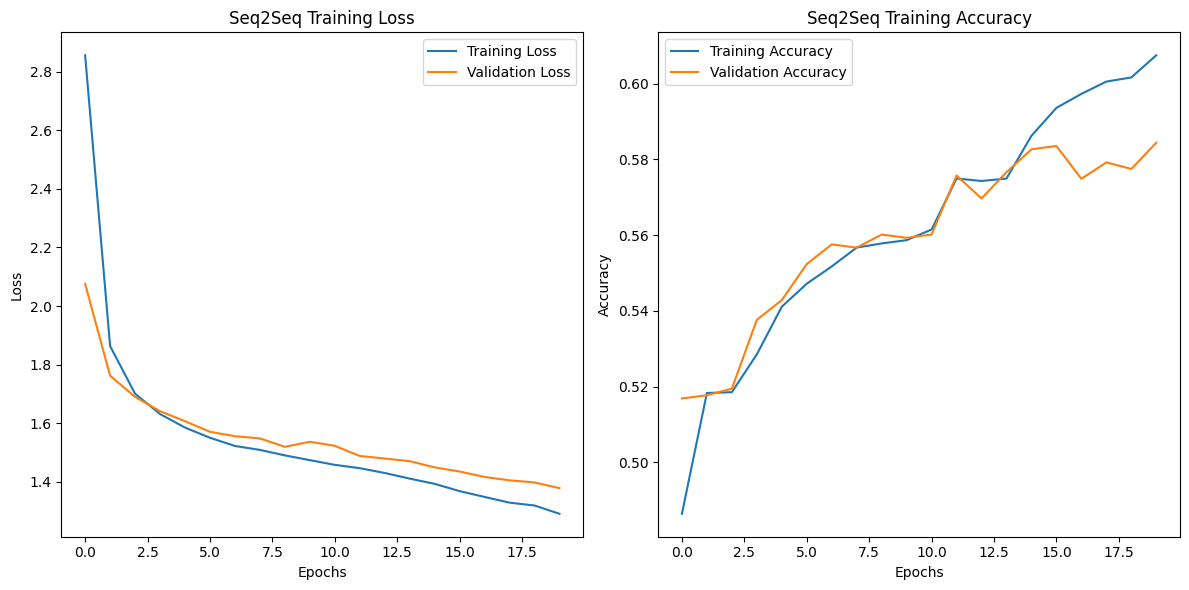

ValueError: Data cardinality is ambiguous:
  x sizes: 132, 524
  y sizes: 132
Make sure all arrays contain the same number of samples.

In [5]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("final.csv")

# Preprocess data: Here we assume your data has 'Incorrect_Word' and 'Correct_Word' columns
# Create a vocabulary and prepare input-output sequences
input_texts = df['Incorrect_Word'].values
output_texts = df['Correct_Word'].values

# Character-level encoding
chars = sorted(list(set(''.join(input_texts) + ''.join(output_texts))))
char_to_index = {char: i + 1 for i, char in enumerate(chars)}  # +1 to avoid 0 index
index_to_char = {i + 1: char for i, char in enumerate(chars)}

# Encode input and output sequences
def encode_sequence(sequence):
    return [char_to_index.get(char, 0) for char in sequence]

input_sequences = [encode_sequence(text) for text in input_texts]
output_sequences = [encode_sequence(text) for text in output_texts]

# Padding sequences to have the same length
max_input_length = max(len(seq) for seq in input_sequences)
max_output_length = max(len(seq) for seq in output_sequences)

input_sequences = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
output_sequences = pad_sequences(output_sequences, maxlen=max_output_length, padding='post')

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(input_sequences, output_sequences, test_size=0.2, random_state=42)

# Seq2Seq Model Architecture
# Encoder
encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(input_dim=len(chars)+1, output_dim=128)(encoder_input)
encoder_lstm = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)

# Decoder
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=len(chars)+1, output_dim=128)(decoder_input)
decoder_lstm = LSTM(128, return_sequences=True)(decoder_embedding, initial_state=[state_h, state_c])
decoder_output = Dense(len(chars)+1, activation='softmax')(decoder_lstm)

# Model
seq2seq_model = Model([encoder_input, decoder_input], decoder_output)

# Compile model
seq2seq_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Prepare decoder input and output for training
decoder_input_train = np.zeros_like(y_train)
decoder_input_train[:, 1:] = y_train[:, :-1]
decoder_input_train[:, 0] = 1  # Start token

# Train the model
history = seq2seq_model.fit([X_train, decoder_input_train], np.expand_dims(y_train, -1),
                            epochs=20, batch_size=32, validation_split=0.2)

# Plotting training loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Seq2Seq Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Seq2Seq Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate model
seq2seq_model.evaluate([X_test, decoder_input_train], np.expand_dims(y_test, -1))
